In [3]:
import torch
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# fix something here maybe in order to have it so that action is adjusted in step function to closest action that is allowed at 7am,
# and so that the action does not result in negative battery level

def get_legal_actions_at_last(all_actions, current_level, min_level=2):
    '''
    Expected behavior: [-2,-1,0,1,2], currently 0 -> [2]
    Expected behavior: [-2,-1,0,1,2], currently 1 -> [1,2]
    Expected behavior: [-2,-1,0,1,2], currently 2 -> [0,1,2]
    Expected behavior: [-2,-1,0,1,2], currently 3 -> [-1,0,1,2]
    Expected behavior: [-2,-1,0,1,2], currently 4 -> [-2,-1,0,1,2]
    '''
    all_actions = np.asarray(all_actions)
    charge_needed = min_level - current_level
    avail_actions = all_actions[np.where(all_actions >= charge_needed)]
    # avail_actions = all_actions[list(np.where(all_actions >= charge_needed)[0])]
    return avail_actions.tolist()

def get_legal_actions(all_actions, current_level, min_level=0):
    all_actions = np.asarray(all_actions)
    underlying_levels = all_actions + current_level
    # avail_actions = all_actions[list(np.where(underlying_levels >= 0)[0])]
    avail_actions = all_actions[np.where(underlying_levels >= min_level)]
    return avail_actions.tolist()

In [79]:
# 1 make the step function go through one hour at a time, and through the entire dataframe (sequentially) in total *
# 2 take at_home out of the state *
# 3 include the action mechanics inside of the step function *
# 4 test environment again on random policy loop *
# 5 try q learning
# 6 change action to -1, 1 range
# 7 change reward calculation *
# 8 test with the test environment (validate using main.py)
# 9 include electricity price, and maybe more time elements in the state representation (week/month/year)
# 10 change hour from 08-07 to 01-00

#
# action comes in in continuous form, is modified in the step function in continuous form within range [-1,1], which
# is used then to update state variables, i.e. battery level, into a continuous variable between [0,50]
# state is returned in continuous form
# in tabular Q learning, state (from env.step) is taken and discretized to get next action
# in approximator methods, state is taken as continuous and used to get next action

class StorageEnv(Env):
    def __init__(self, path_to_train_data):
        '''
        Initialization of the energy storage environment;
        We interpret a run through all historical price data as one trajectory = one episode,
        where for each hour of each day, we can run the step function to update from one state
        to the next, given some action for that hour (the step function will return the next
        state, as well as next reward, and whether the entire historical dataset has been
        iterated through using the 'done' variable in the return statement).
        '''

        self.train_data = pd.read_excel(path_to_train_data)
        self.price_values = self.train_data.iloc[:, 1:25].to_numpy()
        self.timestamps = self.train_data['PRICES']
        self.nr_hours = self.price_values.shape[0]*self.price_values.shape[1] # number of hours in the dataset in total = 25208 for train.xlsx


        self.values_actions =  [-20, -10, 0, 10, 20]
        self.batteries =  [0, 10, 20, 30, 40, 50]
        self.action_repr = [-2,-1,0,1,2]

        self.done = False # indicates whether trajectory (run through entire dataset) has finished, analogous to 'terminated' argument

        self.action_space = Discrete(5, start=-2)
        self.battery_space = Discrete(6, start=0)
        self.position_space = Discrete(2, start=0)

        self.counter = 0
        self.hour = 1
        self.day = 1
        self.num_hours_day = 24

        self.min_battery_level_start = 20
        self.min_battery_level = 0
        self.max_battery_level = 50
        self.max_charging_level = 25

        # battery level from 0 to 50 (10 incr.), indication car at home or not
        self.observation_space = MultiDiscrete([self.battery_space.n,
                                                self.position_space.n,
                                                self.num_hours_day])

        # initialize state vars
        self.battery_level = np.random.randint(self.min_battery_level_start, self.max_battery_level)
        # randomly initialize athome with 50/50 chance of being away at hour 0 (8am) or not
        self.at_home = np.random.randint(self.position_space.n) # dont need this anymore or?
        # initial state
        self.state = [self.battery_level, self.hour]


    def step(self, action):
        ######### at current timestep t
        ### battery comsumption at timestep t

        # no charging/discharging if car is away, besides reduction of batter level by 20kwh at 8am (enforced later on)
        if not self.at_home: # check if car is currently away, enforced by overriding previous if statement
          action = 0

        # meeting constraints of having 20kwh at 7am, and alwys more than 0kwh stored
        elif self.at_home:
          # calculate the exact action you need to get the battery to 20kwh, by taking the min of all sufficient (=legal) actions
          if self.hour == 7:
            legal_actions = get_legal_actions_at_last(self.action_repr, self.battery_level)
            if action not in legal_actions: # check if action chosen by agent ensures 20kwh of battery at 7am
              action = min(legal_actions)
          # rest of the day, ensure that battery stays above 0kwh
          else:
            legal_actions = get_legal_actions(self.action_repr, self.battery_level)
            if action not in legal_actions:
              action = min(legal_actions)

        # removing 20kwh from battery when going away from home
        if not self.at_home:
          self.battery_level = self.battery_level-2 if self.hour == 0 else self.battery_level

        # update battery level based on the picked acion at timestep t
        if self.at_home:
            self.battery_level += action

        # no over-charging above 50kwh
        if self.battery_level >= 5:
            self.battery_level = 5

        # should we move the constraints not lower 0 here ??

        ######### update the state for next hour, timestep t+1
        # keep the hour 8 ~ 18 same, otherwise athome = True
        self.at_home = self.at_home if self.hour < 18 else 1

        # reward calculations
        # if self.day-1 == 1095:
        #   print(f"self.day-1 {self.day-1} | self.hour-1 {self.hour-1}  | self.price_values[self.day-1][self.hour-1] {self.price_values[self.day-1][self.hour-1]}  ")
        hourly_price = self.price_values[self.day-1][self.hour-1]
        cost_factor = 1.0 if action < 0 else 2.0
        efficiency_price_factor = 0.9 if action < 0 else 1.0 # obtained electricity is impacted by 0.9 when selling

        # get amount of kwh bought during this step
        kwhs_charged = action * 10 # change this 10 when changing action space!!!
        price_of_charging = kwhs_charged * cost_factor * efficiency_price_factor * (hourly_price/1000) # go from MWh to KWh, multiply by 2 if we are buying
        # add reward here, based on price from table

        reward = (-1.) * price_of_charging # reward for this step, positive if selling, negative when buying

        # update counter and time variables
        self.counter += 1 # update continuous counter (running from 0 - len(df)*24)
        self.hour += 1 # increment hour (running from 1-24 and back to 1 after the day passed)

        if self.counter % 24 == 0: # check if day is over, meaning that it is midnight at timestep t+1
            self.hour = 1 # reset hour of the day for next timestep
            self.day += 1 # increment to start of next day

        # update state
        self.state = [self.battery_level, self.hour]

        # check if all hours in the dataset have been seen
        self.done = self.counter+1 == self.nr_hours

        truncated = False
        info = {}

        return self.state, reward, self.done, truncated, info

    def render(self):
        pass

    def reset(self):
      # initialize battery level randomly between 0 and 6, representing the space 0-50kwh
      self.battery_level = np.random.uniform(self.min_battery_level_start, self.max_battery_level)
      # randomly initialize athome with 50/50 chance of being away at hour 0 (8am) or not
      self.at_home = np.random.randint(self.position_space.n)
      # hour may not need to be in the state..?
      self.hour = 1
      self.day = 1
      self.counter = 0
      self.done = False
       # initial state
      self.state = [self.battery_level, self.hour]

      return self.state

In [80]:
class QAgent():
    
    def __init__(self, discount_rate = 0.95, bin_size = {'battery': 5, 'hour': 24}):
        
        '''
        Params:
        
        env_name = name of the specific environment that the agent wants to solve
        discount_rate = discount rate used for future rewards
        bin_size = number of bins used for discretizing the state space
        
        '''
        
        #create an environment
        self.env = StorageEnv(path_to_train_data="../data/train.xlsx")
        
        #Set the discount rate
        self.discount_rate = discount_rate
        
        #The algorithm has then 3 different actions
        #0: Accelerate to the left
        #1: Don't accelerate
        #2: Accelerate to the right
        self.action_space = self.env.action_space.n
        self.action_repr = [-2,-1,0,1,2]
        
        #Set the bin size
        self.bin_size = bin_size
        
        # print(self.action_space, self.bin_size)
        
        #State incorporates the observation state
        #State[0] is x position
        #State[1] is velocity
    
        #Get the low and high values of the environment space
        # self.low = self.env.observation_space.low
        # self.high = self.env.observation_space.high
        
        
        self.battery_low = 0
        self.battery_high = 50
        self.hour_low = 0
        self.hour_high = 24
        #Create bins for both observation features, i.e. x-position and velocity

        # self.bin_x = np.linspace(self.low[0], self.high[0], self.bin_size)
        self.bin_battery = np.linspace(self.battery_low, self.battery_high, self.bin_size['battery'] + 1)  # might add 2 : 0, 50  ??  7
        # print(self.bin_battery)

        # print(f"self.bin_x:  {self.low[0]} | {self.high[0]} | {self.bin_size} |{self.bin_x }")
    
        '''
        ToDo:
        
        Please create the bins for the velocity feature in the same manner and call this variable self.bin_velocity!
        '''
                
        #Solution
        # self.bin_velocity = np.linspace(self.low[1], self.high[1], self.bin_size)
        # array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])
        self.bin_hour = np.linspace(0, 24, self.bin_size['hour'] + 1 )  # 0-1 -> 1   24
        # print(self.bin_hour)
        
        #Append the two bins
        # self.bins = [self.bin_x, self.bin_velocity]
        self.bins = [self.bin_battery, self.bin_hour]
        
    
    def discretize_state(self, state):
        
        '''
        Params:
        state = state observation that needs to be discretized
        
        
        Returns:
        discretized state
        '''
        #Now we can make use of the function np.digitize and bin it
        self.state = state
        # print(f"self.state: {self.state}")
        
        #Create an empty state
        digitized_state = []
    
        # battery -> bin0: -inf~0 bin1: 0~10, ... bin6: 50~inf   
        # print(f"np.digitize(self.state[0], self.bins[0]): {np.digitize(self.state[0], self.bins[0])}")
        # print(f"battery: {self.state[0]}, bins: {self.bins[0]}")
        # print(f"at which bin: {np.digitize(self.state[0], self.bins[0])}")
        digitized_state.append(np.digitize(self.state[0], self.bins[0], right=False)-1)  # battery ??   0, 1, 2, 3, 4, 5   from [-inf, 0) is not considered
        # hour -> bin0: 0~1 bin1: 1~2, ... bin23: 23~24, bin24: 24-inf (never reach)  
        # print(f"np.digitize(self.state[1], self.bin_hour[1]): {np.digitize(self.state[1], self.bins[1])}")
        
        # self.state[1] = 1
        # hour: 0.5, bins: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24.]   .->
        # print(f"hour: {self.state[1]}, bins: {self.bins[1]}")
        # print(f"at which bin: {np.digitize(self.state[1], self.bins[1], right=True)}") 
        digitized_state.append(np.digitize(self.state[1], self.bins[1], right=True)-1)  # hour   0, 1, 2 ... 23, 24   from [-inf,0]  is not considered
        
        # for i in range(len(self.bins)):
        #     # print(f"self.state[i], self.bins[i]: {self.state[i]}, {self.bins[i]}")
        #     # print(f"np.digitize(self.state[i], self.bins[i]): {np.digitize(self.state[i], self.bins[i])}")
        #     digitized_state.append(np.digitize(self.state[i], self.bins[i])-1)  ##
        #     # print(f"np.digitize(self.state[i], self.bins[i])-1: {np.digitize(self.state[i], self.bins[i])-1}")
        
        #Returns the discretized state from an observation
        return digitized_state
    
    def discretize_action(self, action=1.0):
        digitized_action = action
        return digitized_action
    
    def create_Q_table(self):
        # self.state_space = self.bin_size - 1
        #Initialize all values in the Q-table to zero
        self.state_battery_space = self.bin_size['battery']
        self.state_hour_space = self.bin_size['hour']
        
        '''
        ToDo:
        Initialize a zero matrix of dimension state_space * state_space * action_space and call it self.Qtable!
        '''
        
        #Solution:
        # self.Qtable = np.zeros((self.state_space, self.state_space, self.action_space))
        self.Qtable = np.zeros((self.state_battery_space, self.state_hour_space, self.action_space))
        # print(self.Qtable.shape)
        

    def train(self, simulations, learning_rate, epsilon = 0.05, epsilon_decay = 1000, adaptive_epsilon = False, 
              adapting_learning_rate = False):
        
        '''
        Params:
        
        simulations = number of episodes of a game to run
        learning_rate = learning rate for the update equation
        epsilon = epsilon value for epsilon-greedy algorithm
        epsilon_decay = number of full episodes (games) over which the epsilon value will decay to its final value
        adaptive_epsilon = boolean that indicates if the epsilon rate will decay over time or not
        adapting_learning_rate = boolean that indicates if the learning rate should be adaptive or not
        
        '''
        
        #Initialize variables that keep track of the rewards
        
        self.rewards = []
        self.average_rewards = []
        
        #Call the Q table function to create an initialized Q table
        self.create_Q_table()
        
        #Set epsilon rate, epsilon decay and learning rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        
        #Set start epsilon, so here we want a starting exploration rate of 1
        self.epsilon_start = 1
        self.epsilon_end = 0.05
        
        #If we choose adaptive learning rate, we start with a value of 1 and decay it over time!
        if adapting_learning_rate:
            self.learning_rate = 1
        
        for i in range(simulations):
            
            if i % 5000 == 0:
                print(f'Please wait, the algorithm is learning! The current simulation is {i}')
            # print(f'Please wait, the algorithm is learning! The current simulation is {i}')           
            #Initialize the state
            # state = self.env.reset()[0]   # reset returns a dict, need to take the 0th entry.
            state = self.env.reset()   # reset returns a dict, need to take the 0th entry.
        
            #Set a variable that flags if an episode has terminated
            done = False
        
            #Discretize the state space
            # print(f"state: {state}")
            state = self.discretize_state(state)
            # print(f"discretize_state state: {state}")
            
            
            #Set the rewards to 0
            total_rewards = 0
            
            #If adaptive epsilon rate
            # self.epsilon_start = 1
            # self.epsilon_end = 0.05
            # epsilon = 0.05
            # epsilon_decay = 1000
            if adaptive_epsilon:
                self.epsilon = np.interp(i, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
                
                #Logging just to check it decays as we want it to do, we just print out the first three statements
                if i % 500 == 0 and i <= 1500:
                    print(f"The current epsilon rate is {self.epsilon}")
                
            #Loop until an episode has terminated
            while not done:
                
                #Pick an action based on epsilon greedy
                
                '''
                ToDo: Write the if statement that picks a random action
                Tip: Make use of np.random.uniform() and the self.epsilon to make a decision!
                Tip: You can also make use of the method sample() of the self.env.action_space 
                    to generate a random action!
                '''
                
                #Solution:
                
                #Pick random action
                if np.random.uniform(0, 1) > 1-self.epsilon:
                    #This picks a random action from 0,1,2
                    action = self.env.action_space.sample()
                    
                #Pick a greedy action
                else:
                    action = np.argmax(self.Qtable[state[0],state[1],:])
                    
                #Now sample the next_state, reward, done and info from the environment
                
                next_state, reward, terminated, truncated, info = self.env.step(action) # step returns 5 outputs
                done =  terminated or truncated
                
                #Now discretize the next_state
                next_state = self.discretize_state(next_state)
                
                #Target value 
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state[0], next_state[1]]))
                
                #Calculate the Temporal difference error (delta)
                delta = self.learning_rate * (Q_target - self.Qtable[state[0], state[1], action])
                
                #Update the Q-value
                self.Qtable[state[0], state[1], action] = self.Qtable[state[0], state[1], action] + delta
                
                #Update the reward and the hyperparameters
                total_rewards += reward
                state = next_state
                
            
            if adapting_learning_rate:
                self.learning_rate = self.learning_rate/np.sqrt(i+1)
            
            self.rewards.append(total_rewards)
            
            #Calculate the average score over 100 episodes
            if i % 100 == 0:
                self.average_rewards.append(np.mean(self.rewards))
                
                #Initialize a new reward list, as otherwise the average values would reflect all rewards!
                self.rewards = []
        
        print('The simulation is done!')
        
    def visualize_rewards(self):
        plt.figure(figsize =(7.5,7.5))
        plt.plot(100*(np.arange(len(self.average_rewards))+1), self.average_rewards)
        plt.axhline(y = -110, color = 'r', linestyle = '-')
        plt.title('Average reward over the past 100 simulations', fontsize = 10)
        plt.legend(['Q-learning performance','Benchmark'])
        plt.xlabel('Number of simulations', fontsize = 10)
        plt.ylabel('Average reward', fontsize = 10)
            
    def play_game(self):
        # Make eval env which renders when taking a step
        # eval_env = gym.make(env_name, render_mode='human')
        eval_env = StorageEnv(path_to_train_data="../data/validate.xlsx")
        state = eval_env.reset()
        done=False
        # Run the environment for 1 episode
        while not done:
            state = self.discretize_state(state)
            action = np.argmax(self.Qtable[state[0],state[1],:])
            next_state, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            state = next_state
        eval_env.close()


In [81]:
#You can change the learning rate and the number of simulations if you want (yet, it will take then of course longer)!
simulations = 15000
learning_rate = 0.10

'''
ToDo:
Initialize the Qagent and call the instance agent!
Afterwards,let it train over the number of simulations with the specific learning rate!
'''

#WRITE YOUR CODE HERE!
#With standard epsilon_greedy
agent_standard_greedy = QAgent()
agent_standard_greedy.train(simulations, learning_rate)

Please wait, the algorithm is learning! The current simulation is 0


KeyboardInterrupt: 

At episode 1, total electricity expenditure is: -10783.128680000014


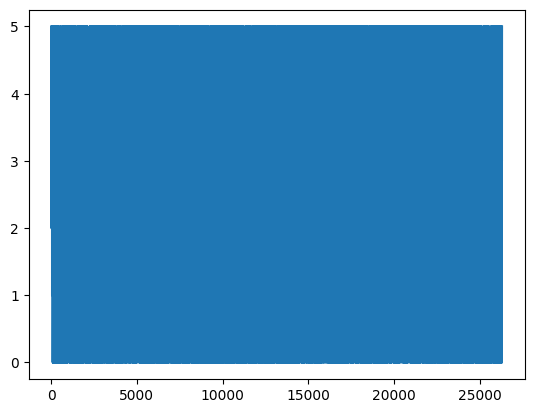

In [7]:
# env = StorageEnv("../data/train.xlsx")

# total_cost = 0.0
# action_repr = [-2,-1,0,1,2]
# battery_charges = []

# for episode in range(1):
#     # current_day_prices = prices.iloc[episode].tolist()
#     # env.reset() # fix the reset function and uncomment when running >1 episodes
#     battery_level, hour = env.state
#     done=False

#     while not done:
#       action = random.choice(action_repr)
#       # print(env.counter) # counter goes until 26302 = 25208 + 1096, not sure why
#       state, reward, done, truncated, info = env.step(action) # get the new state
#       battery_level, hour = state

#       battery_charges.append(battery_level)

#       total_cost += reward

#     # finished, all hours*days have been seen
#     print(f"At episode {episode+1}, total electricity expenditure is: {total_cost}")

# # restrict actions for selling

# plt.plot(battery_charges)